# 시계열 데이터확인
## 1. 작업 준비
#### 패키지 및 데이터 가져오기
- kings 데이터는 영국 왕 42명의 사망 시 나이 데이터를 정리한 csv 파일
- `비계절성`을 띄는 시계열 자료
- 20번째 왕까지는 38세에서 55까지 수명을 유지하고, 그 이후부터는 수명이 늘어서 40번째 왕은 73세까지 생존

In [2]:
from pandas import read_excel
from matplotlib import pyplot as plt
import seaborn as sb
import sys

In [3]:
df = read_excel('https://data.hossam.kr/E06/kings.xlsx')
df

,age
0,60
1,43
2,67
3,50
4,56
5,42
6,50
7,65
8,68
9,43


#### 그래프 초기화

In [4]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

## 2. 데이터 살펴보기
### 기초 통계량

In [5]:
df.describe()

,age
count,42.000000
mean,55.285714
std,16.569566
min,13.000000
25%,44.000000
50%,56.000000
75%,67.750000
max,86.000000


### 기본 형태의 시계열 그래프

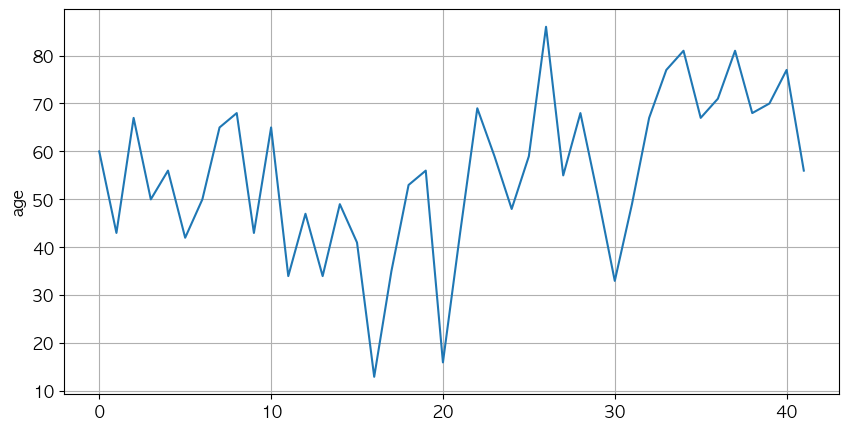

In [6]:
plt.figure()
sb.lineplot(df, x=df.index, y='age')
plt.grid()
plt.show()
plt.close()

### 평균 이동
- 주어진 구간의 평균을 구해서 이어서 표시하는 방법
- 평균 이동 결과가 실제 데이터와 얼마나 차이가 나는지의 여부로 데이터를 판단
#### 1) 단순 이동평균 (SMA, Simple Moving Average)
- 가장 많이 사용하는 방식
- `컬럼.rolling(n).mean()`
    - `.rolling(n)` -> n개씩 묶는다는 개념
##### 3년, 6년, 9년 단위 평균

    age       sma3       sma6       sma9
0    60        NaN        NaN        NaN
1    43        NaN        NaN        NaN
2    67  56.666667        NaN        NaN
3    50  53.333333        NaN        NaN
4    56  57.666667        NaN        NaN
5    42  49.333333  53.000000        NaN
6    50  49.333333  51.333333        NaN
7    65  52.333333  55.000000        NaN
8    68  61.000000  55.166667  55.666667
9    43  58.666667  54.000000  53.777778
10   65  58.666667  55.500000  56.222222
11   34  47.333333  54.166667  52.555556
12   47  48.666667  53.666667  52.222222
13   34  38.333333  48.500000  49.777778
14   49  43.333333  45.333333  50.555556
15   41  41.333333  45.000000  49.555556
16   13  34.333333  36.333333  43.777778
17   35  29.666667  36.500000  40.111111
18   53  33.666667  37.500000  41.222222
19   56  48.000000  41.166667  40.222222
20   16  41.666667  35.666667  38.222222
21   43  38.333333  36.000000  37.777778
22   69  42.666667  45.333333  41.666667
23   59  57.0000

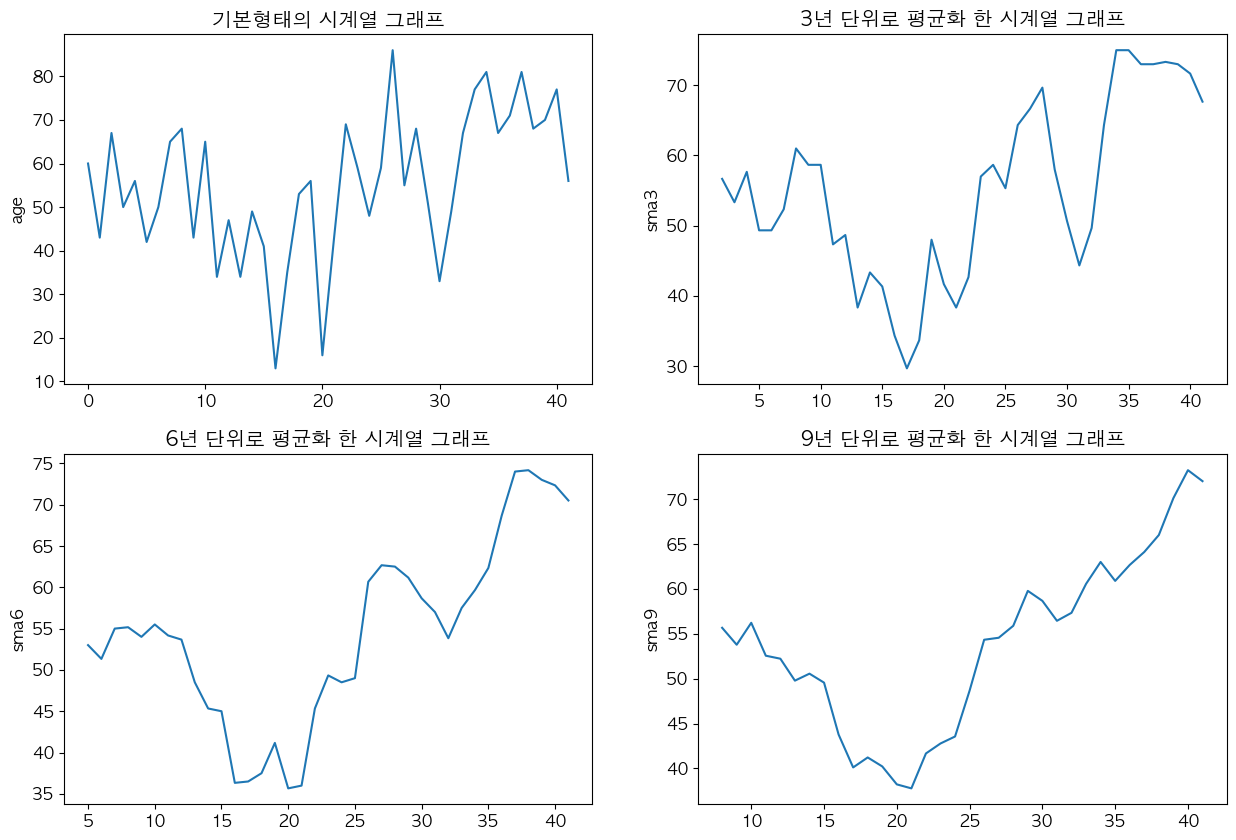

In [9]:
df['sma3'] = df['age'].rolling(3).mean()
df['sma6'] = df['age'].rolling(6).mean()
df['sma9'] = df['age'].rolling(9).mean()
print(df)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,
                                             ncols=2,
                                             figsize=(15,10))
sb.lineplot(df, x=df.index, y='age', ax=ax1)
ax1.set_title('기본형태의 시계열 그래프')
sb.lineplot(df, x=df.index, y='sma3', ax=ax2)
ax2.set_title('3년 단위로 평균화 한 시계열 그래프')
sb.lineplot(df, x=df.index, y='sma6', ax=ax3)
ax3.set_title('6년 단위로 평균화 한 시계열 그래프')
sb.lineplot(df, x=df.index, y='sma9', ax=ax4)
ax4.set_title('9년 단위로 평균화 한 시계열 그래프')
plt.show()
plt.close()

#### 2) 지수 이동평균 (EMA, Exponential Moving Average)
- 보다 최근의 값에 가중치를 두면서 이동평균을 계산하는 방법
- `컬럼.ewm(n).mean()`
    - `ewm(n)` -> n개씩 묶는다는 개념
##### 3년, 6년, 9년 단위 평균

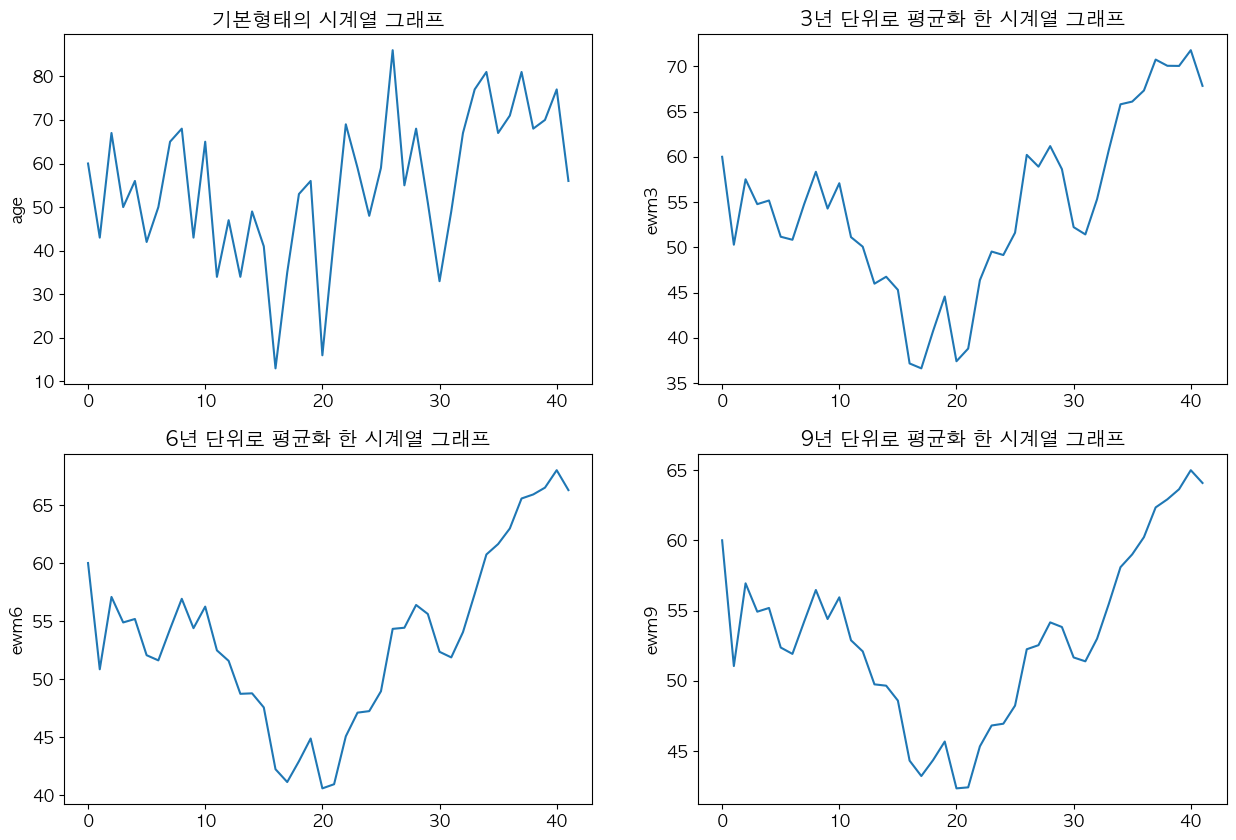

In [11]:
df['ewm3'] = df['age'].ewm(3).mean()
df['ewm6'] = df['age'].ewm(6).mean()
df['ewm9'] = df['age'].ewm(9).mean()

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows=2,
                                            ncols=2,
                                            figsize=(15, 10))
sb.lineplot(df, x=df.index, y='age', ax=ax1)
ax1.set_title('기본형태의 시계열 그래프')
sb.lineplot(df, x=df.index, y='ewm3', ax=ax2)
ax2.set_title('3년 단위로 평균화 한 시계열 그래프')
sb.lineplot(df, x=df.index, y='ewm6', ax=ax3)
ax3.set_title('6년 단위로 평균화 한 시계열 그래프')
sb.lineplot(df, x=df.index, y='ewm9', ax=ax4)
ax4.set_title('9년 단위로 평균화 한 시계열 그래프')
plt.show()
plt.close()

> 평균이동 시각화의 목적은 데이터가 정상성을 만족하는지 확인하여 차분 적용 여부를 결정하기 위함(거의 99% 이상이 비정상성)